# Introduction

This is my first public notebook, I will try my best to make it interesting but I am counting on you to help me improve along the way !

It is divided in two main parts : first an EDA of the Lichess games dataset, and then a prediction experience using various models.
As a chess player myself, I spent some time analysing more in depth the openings in this data, along with the impacts of the ratings gap between players.

Let's start !

# Exploratory Data Analysis (EDA)

First of all, loading the data :

In [ ]:
# All used imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from collections import Counter, OrderedDict
from scipy.ndimage.filters import gaussian_filter1d
import textwrap
from scipy import stats

In [ ]:
# Get the data from a csv file
data_dir = '../input/chess/games.csv'
missing_values = ["n/a", "na", "--"]
data = pd.read_csv(data_dir, na_values=missing_values)

1. About the dataset

In [ ]:
# Headers and number of data points
lines = data.values
headers = data.columns.tolist()
print('Headers: ', headers)
print('Number of rows: ', len(lines))

In [ ]:
# Is the dataset clean ?
print('Missing values summary:')
print(data.isnull().sum())

We have 20 058 game entries, without a single missing value ! That's a good start.
Let's take a overall look at each column, in order to spot global tendencies and maybe a few entries to drop.

In [ ]:
# Unique value count
unique_val_count = np.zeros(len(headers))
for i, col in enumerate(headers):
    unique_val_count[i] = len(np.unique(data[col]))
x = data.columns.tolist()
plt.bar(x, height=unique_val_count)
plt.ylabel = 'value count'
plt.xticks(rotation=90)
plt.title('Unique value count')
plt.show()

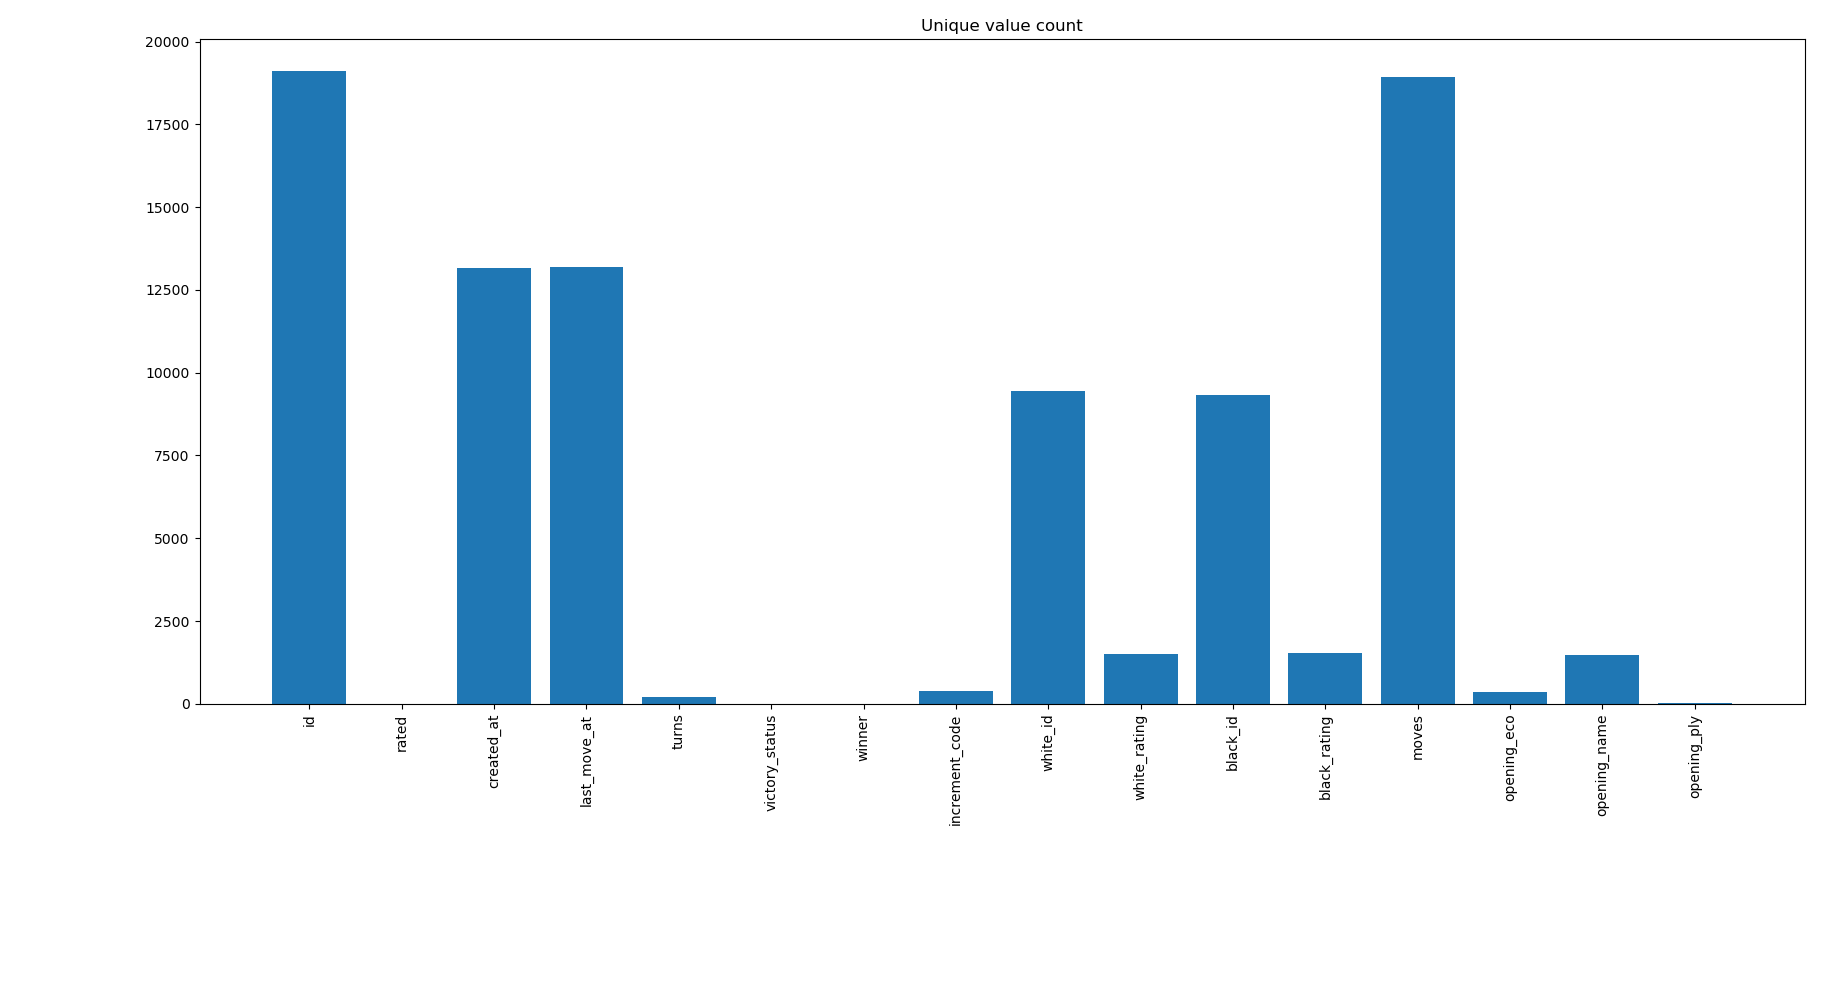

The unique value count graph does not show us many useful information yet, but does confirm the complexity of the game of the chess with several thousands possible moves. With that in mind, I will focus my analysis on simpler information about the games such as the first few moves (openings), because the space of possibilities is too large.

Let's now have a closer look at each column, starting with the distribution of games over time.

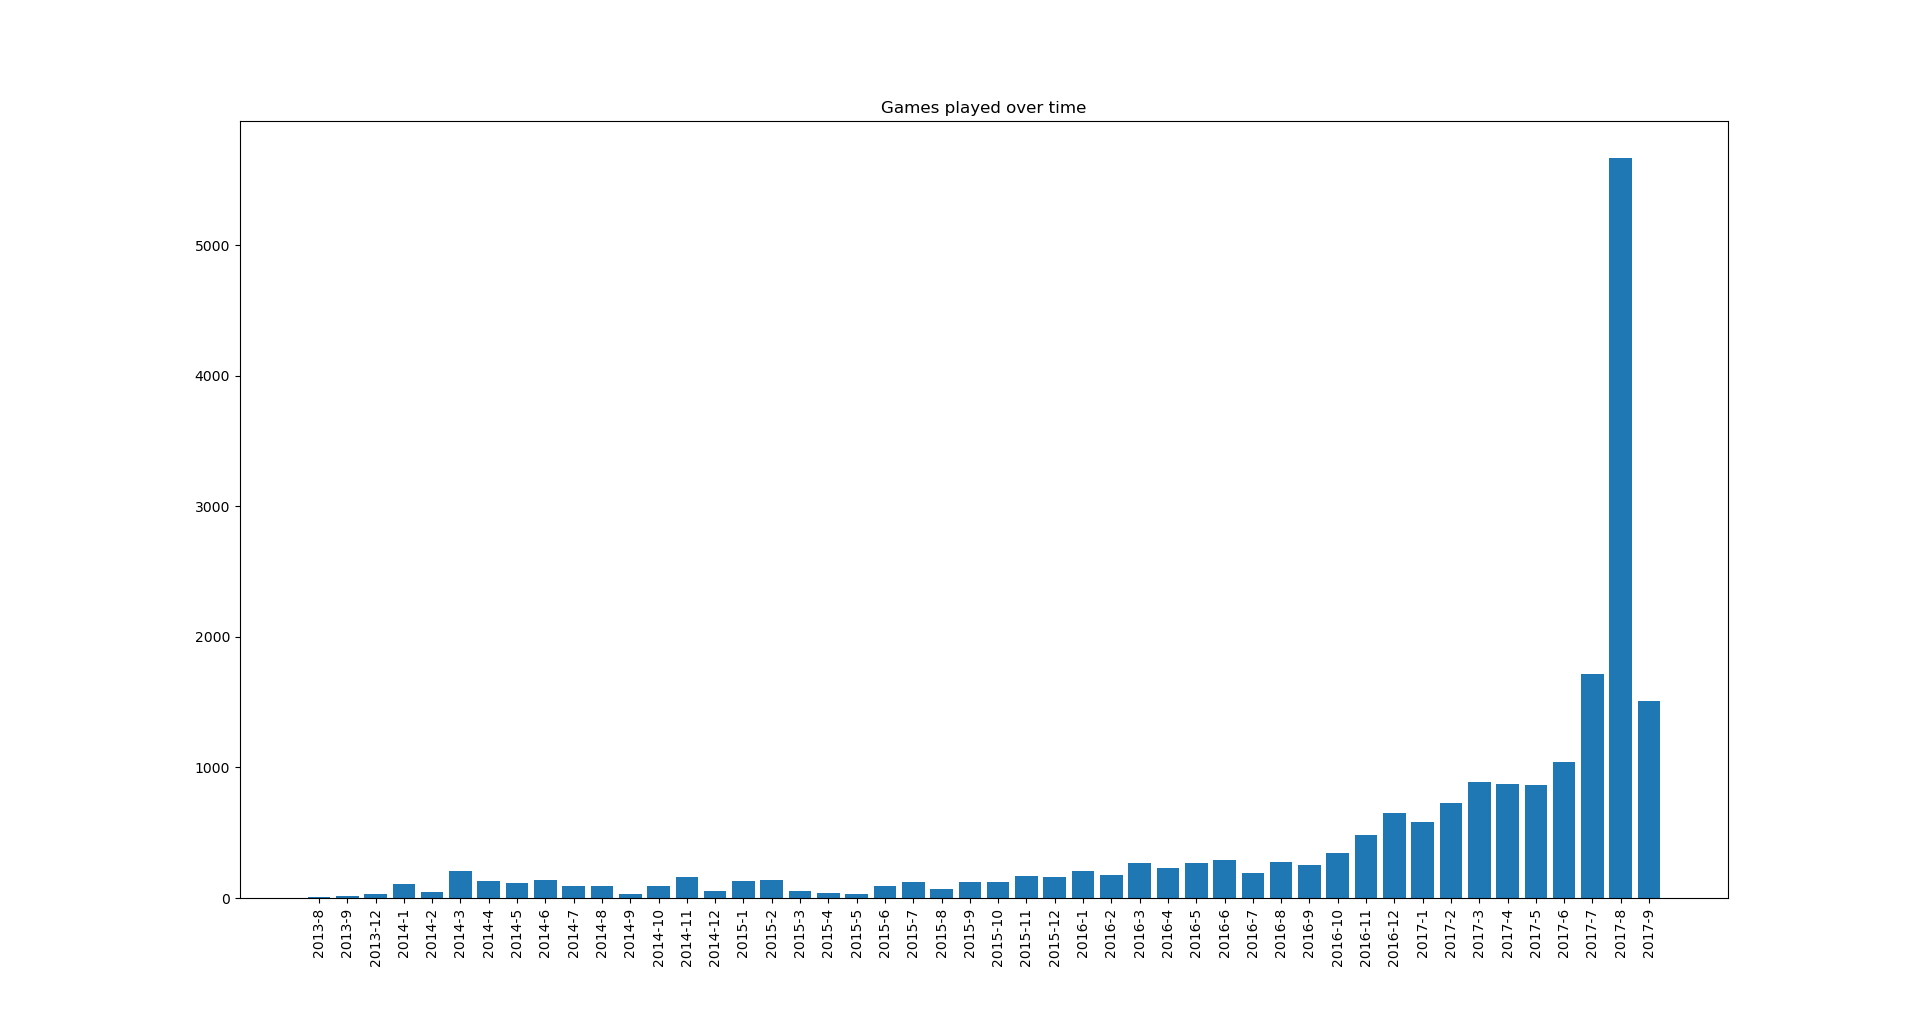

A rather suprising peak occured in august 2017, it would be interesting to search its cause. Maybe on media boost such as the one online chess has recently experienced with the Queen's Gambit Netflix series. Even without this, the number of games seems to increase faster with time.

In [ ]:
# Column analysis : games date
date_of_games = pd.to_datetime(data['created_at'], unit='ms', origin='unix')
date_of_games = date_of_games.sort_values(ascending=True)
date_of_games = [(str(game.date().year) + '-' + str(game.date().month))for game in date_of_games]
date_counter = Counter(date_of_games)
x = list(date_counter.keys())
y = list(date_counter.values())
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel = 'nb. of games'
plt.title('Games played over time')

Next we will look at the distribution of players'ratings.

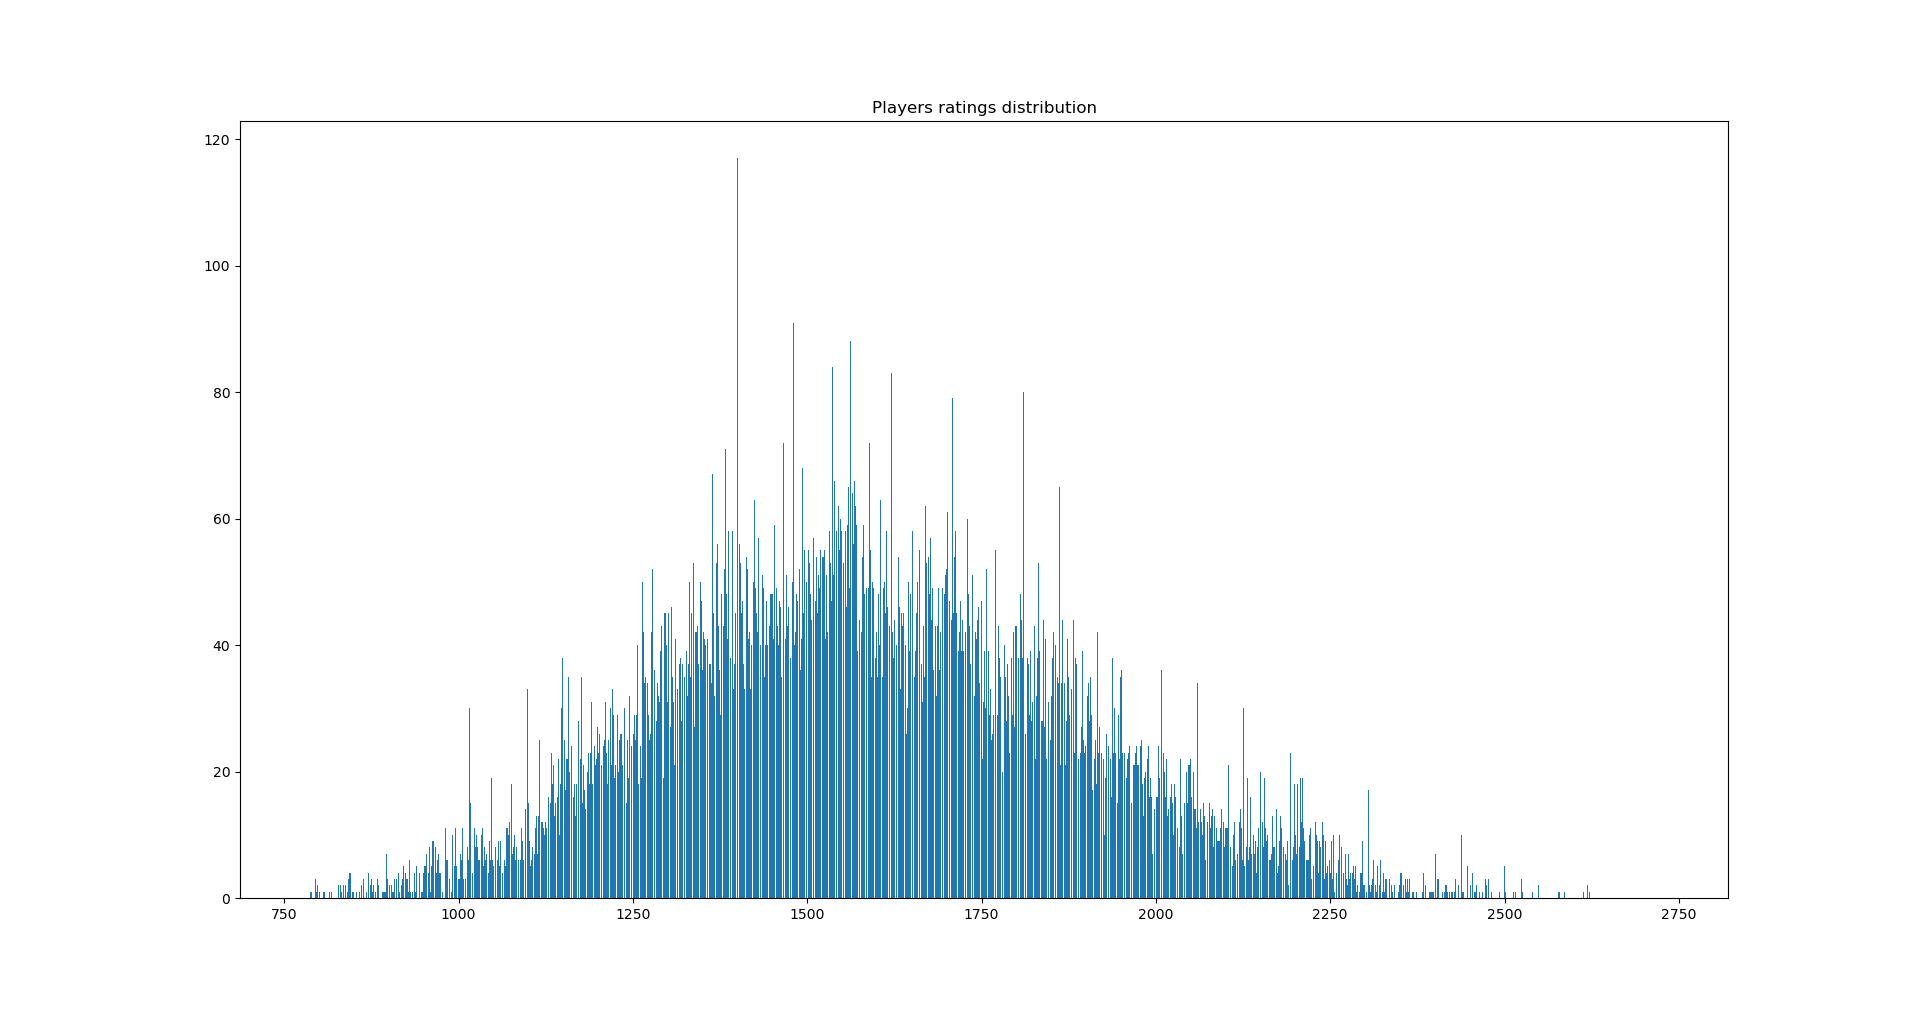

There we have a quite obvious but nvertheless powerful observation which is the result of Lichess' default rating when a new player creates an account : 1500.
I have volontarilly dropped this value because it is over-represented compared to the rest. Still, the ratings follows a Gaussian-like distribution around this key value.

In [ ]:
# Column analysis : ratings
xw = data['white_rating']
xb = data['black_rating']
x = np.concatenate((xw, xb))
x, y = np.unique(x, return_counts=True)
default_rating_index = np.argmax(y)
print(y[default_rating_index])
print(x[default_rating_index])
x = np.delete(x, default_rating_index)
y = np.delete(y, default_rating_index)
plt.bar(x, y)
plt.title('Players ratings distribution')

Next we will look at the games formats. There are quite a lot, so I will only show the most used ones. We can see that the most popular formats are 10 and 15 minutes (with various increment types).

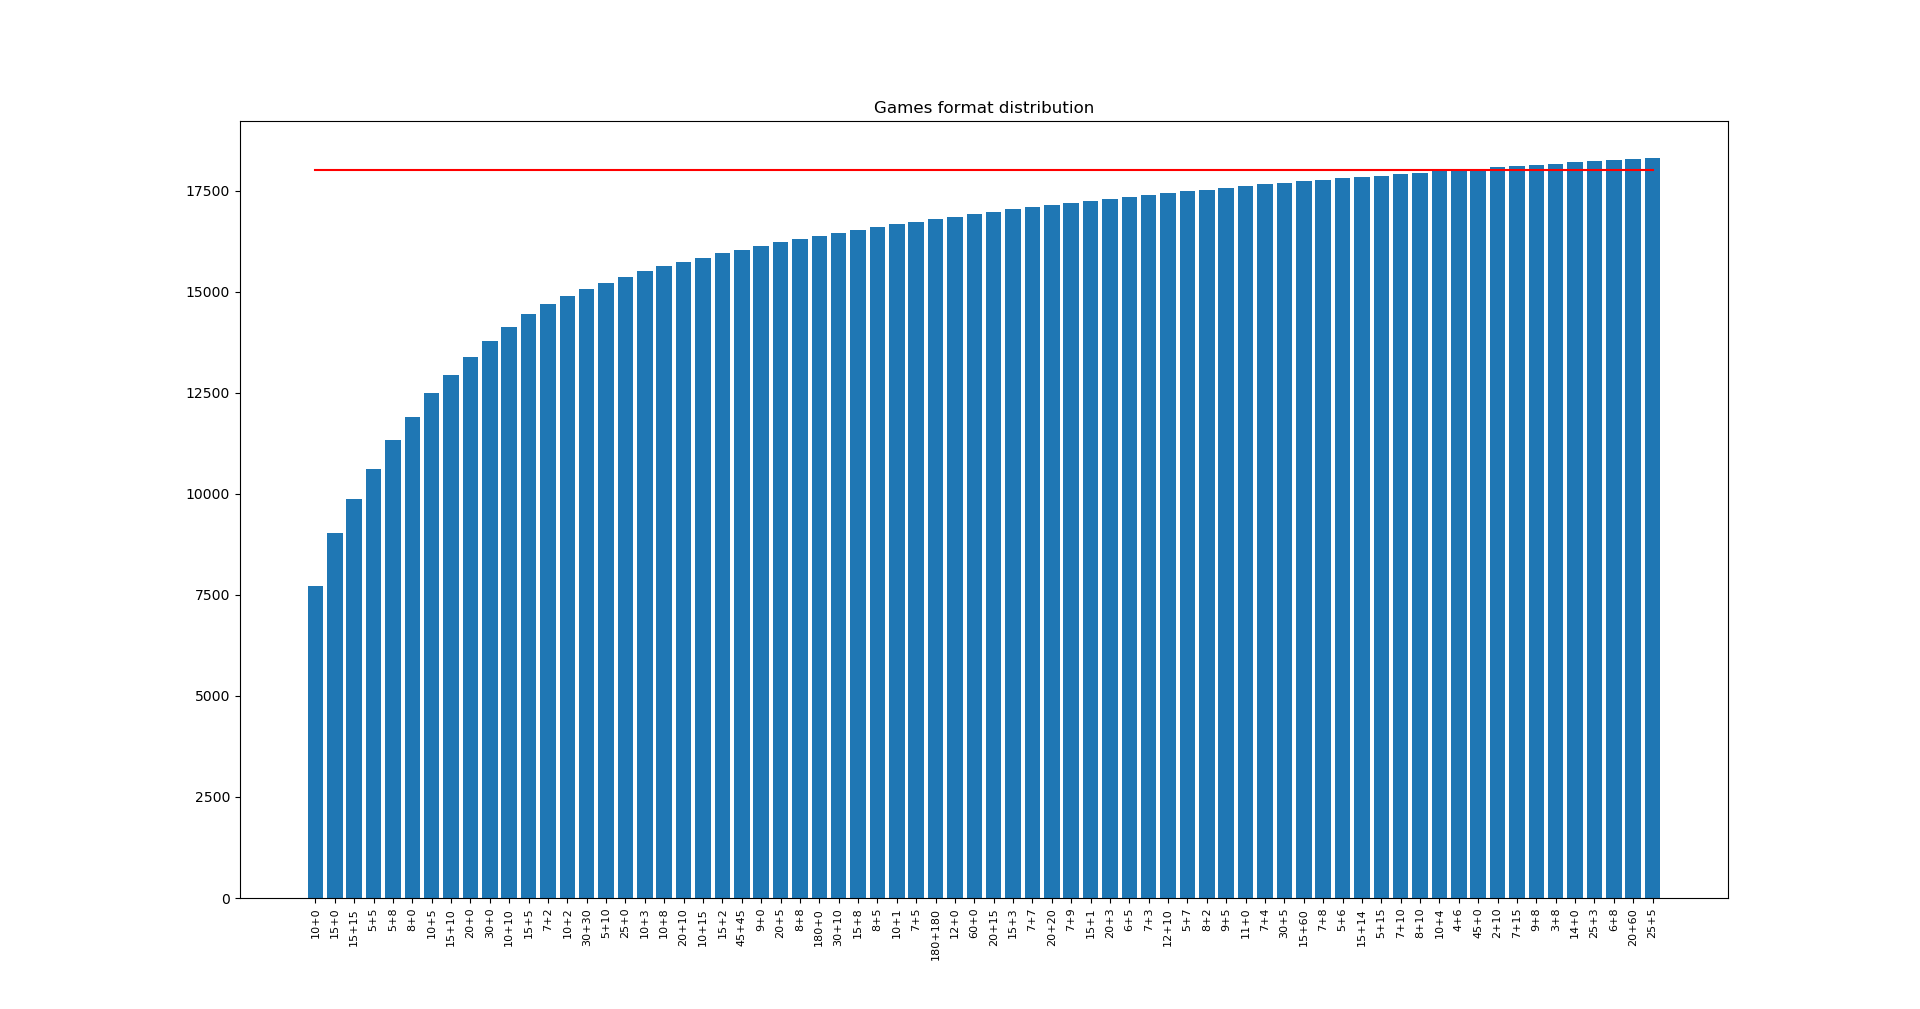

In [ ]:
# Column analysis ; increment_code
limit = 70
increment_codes = data['increment_code']
counter = Counter(increment_codes)
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
x = list(counter.keys())
y = list(counter.values())
y = [(val + sum(y[0:i])) for i, val in enumerate(y)]
plt.bar(x[:limit], y[:limit])
plt.plot(x[:limit], np.full(limit, 18000), color='r')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel = 'Frequency'
plt.title('Games format distribution')

Next we will look at the number of moves per games. The graph shows another Gaussian-like distribution centered around 50-60 moves, which is coherent with the previous observation about the game durations. 10-15 minutes is hardly enough time for the players to make so many moves. Also we can ignore the first high peak which is very likely for all early renditions because of blunders or even disconnections of one player.

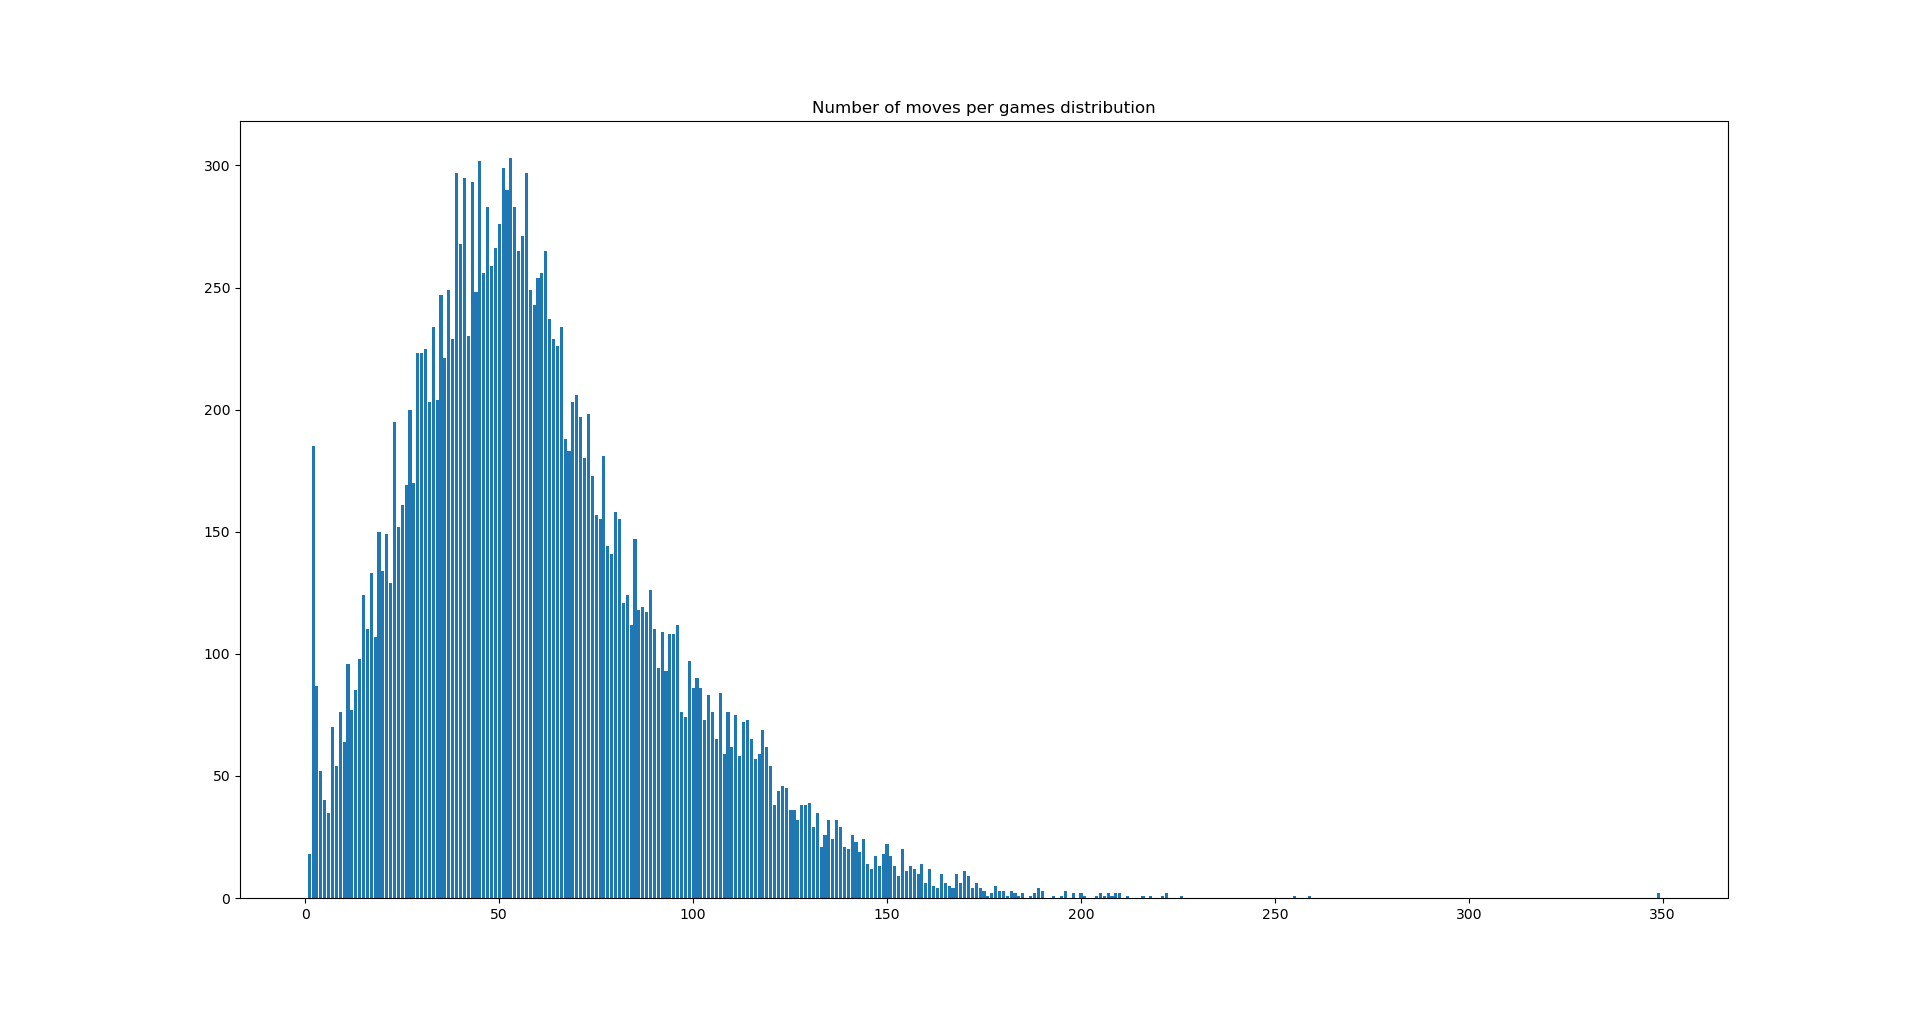

In [ ]:
# Column analysis : turns - number of moves
x, y = np.unique(data['turns'], return_counts=True)
plt.bar(x, y)
plt.title('Number of moves per games distribution')

Next we look at the rated games distribution. Not much that I deduce from here, but it is somewhat reassuring that there is a vast majority of rated games that makes the data more trustworthy : games must have been played seriously (no trolling...) in order for the dataset to be legit.

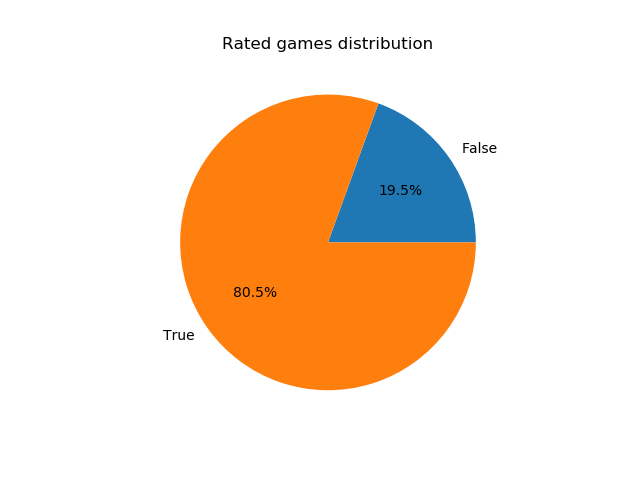

In [ ]:
# Column analysis : rated
x, y = np.unique(data['rated'], return_counts=True)
plt.pie(y, labels=x, autopct='%.1f%%')
plt.title('Rated games distribution')

Next we will look at the winners distribution. Withe's win rate is slightly higher than Black's, coherent with the known fact that White has the advantage in the game of chess.

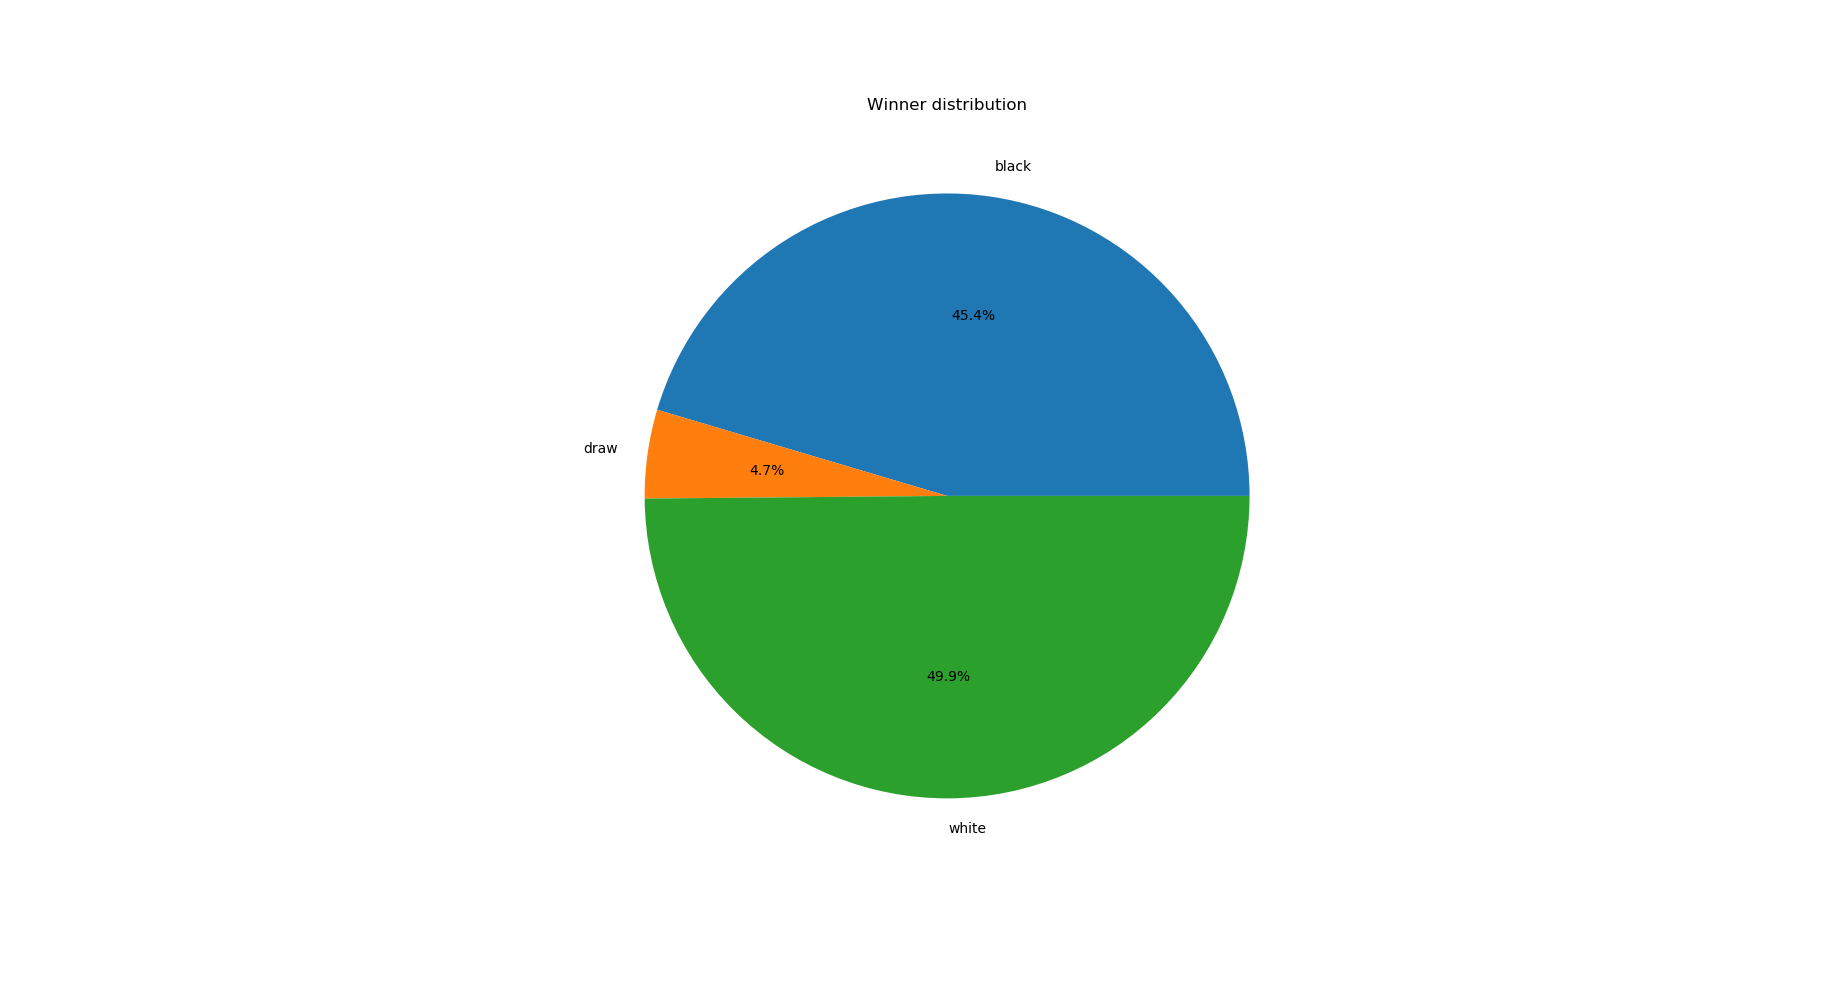

In [ ]:
# Column analysis : winner
x, y = np.unique(data['winner'], return_counts=True)
plt.pie(y, labels=x, autopct='%.1f%%')
plt.title('Winner distribution')

Next we look at the victory status distribution. I have no specific observation, we do see a majority of win by resignation but that is all.

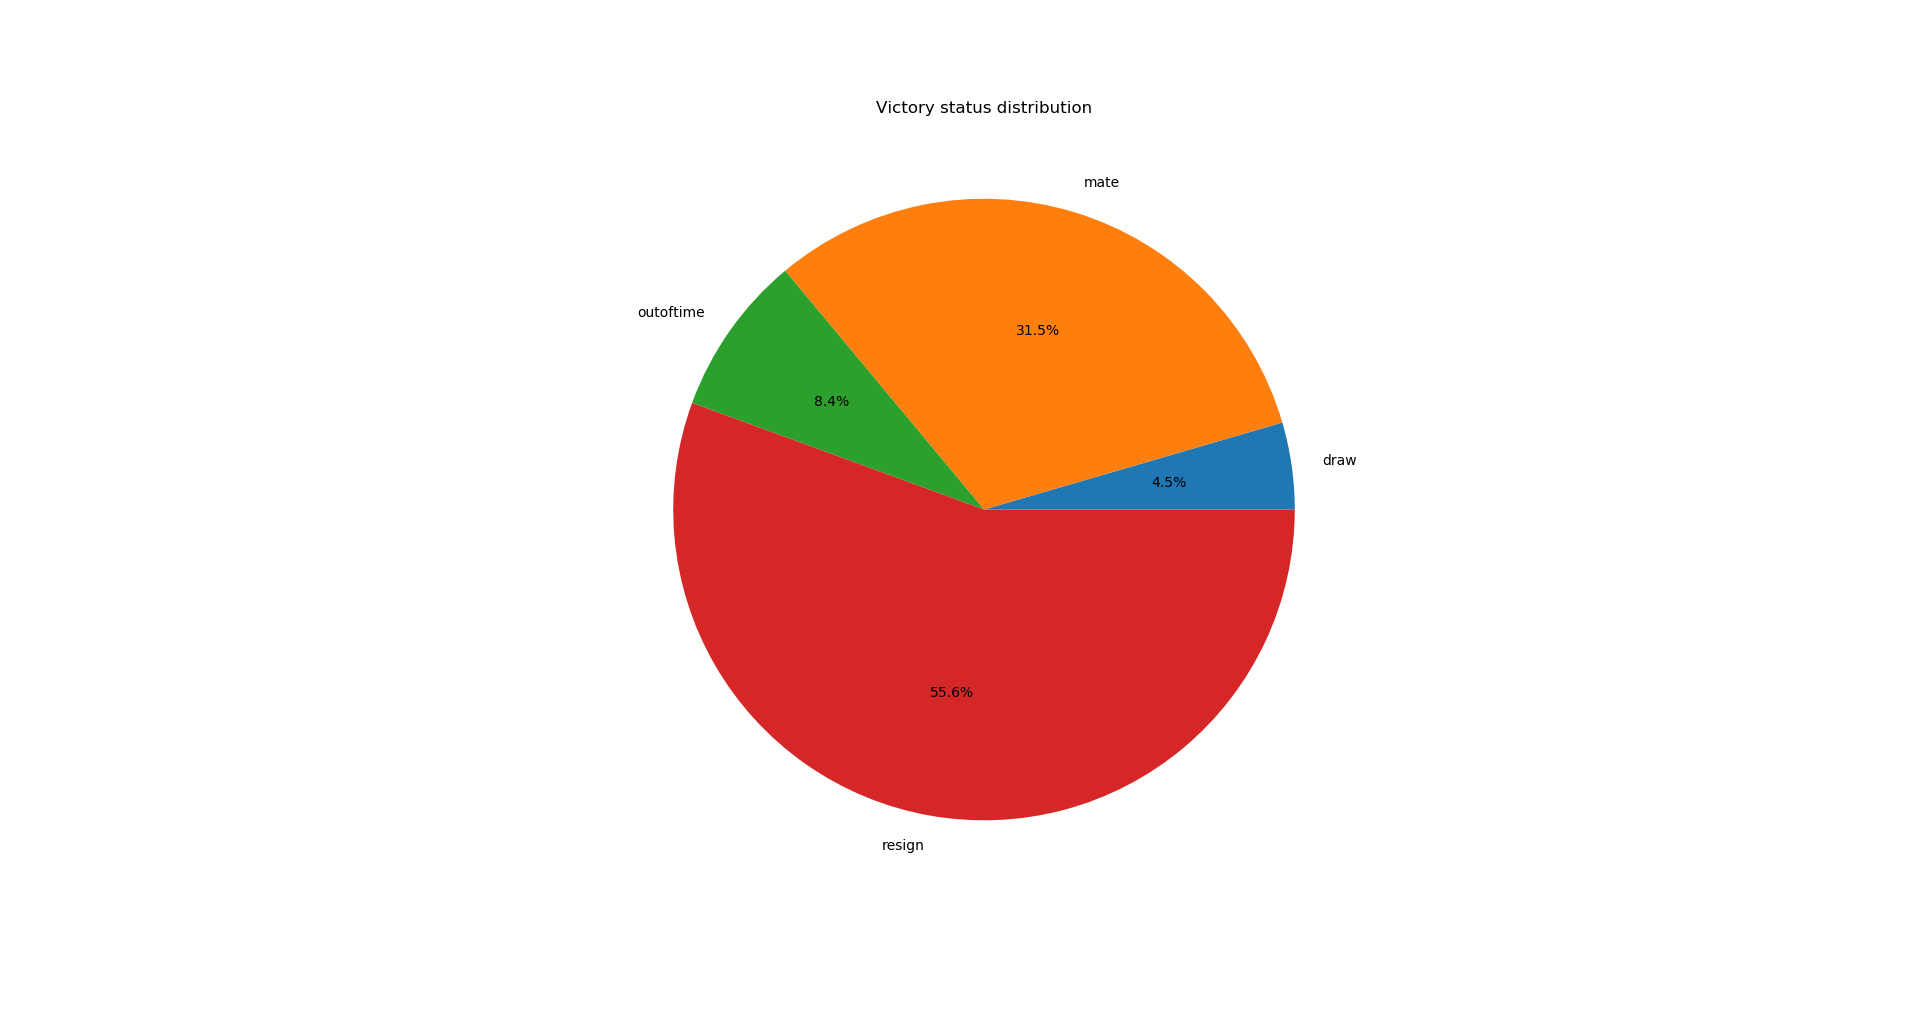

In [ ]:
# Column analysis : victory status
x, y = np.unique(data['victory_status'], return_counts=True)
plt.pie(y, labels=x, autopct='%.1f%%')
plt.title('Victory status distribution')

Finally let's take a brief look at the openings before diving more deeply into it. Problem is there are far too many openings to be displayed on one graph : 1477. I will have to rearrange the openings data before analysing it.

2. About chess

* Openings

One intuitive way to reduce dimensionality of the openings data is to regroup its labels into larger categories. For example all variations of the Sicilian Defense will be labeled with one category, and same goes for the Scandinavian, the French, etc... After this simplification, we are left with 64 openings which is much easier to analyse already !
Here is the distribution of these main openings :

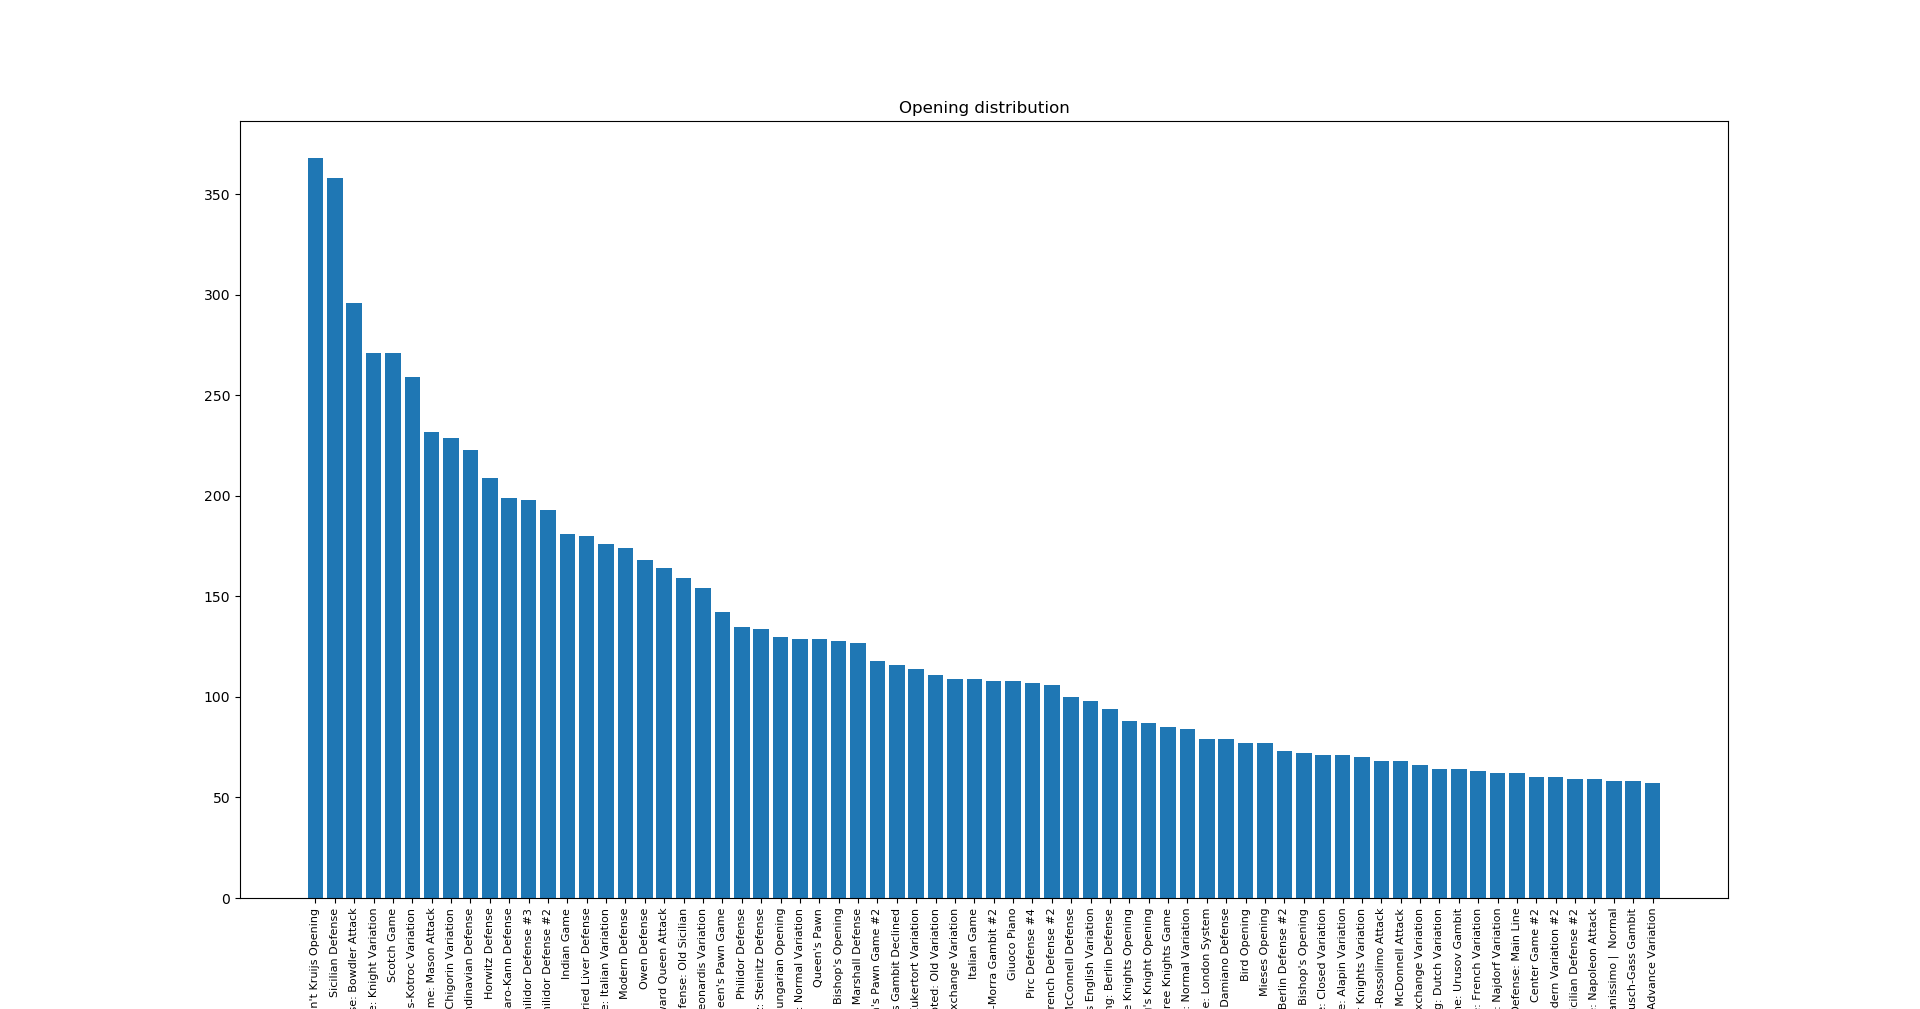


* Main Openings

For a given list of the most played openings at 1500 elo, it is very interesting to see that Black's chances increase a lot if these opening are played at higher level.

For low rated players (elo <= 1500)
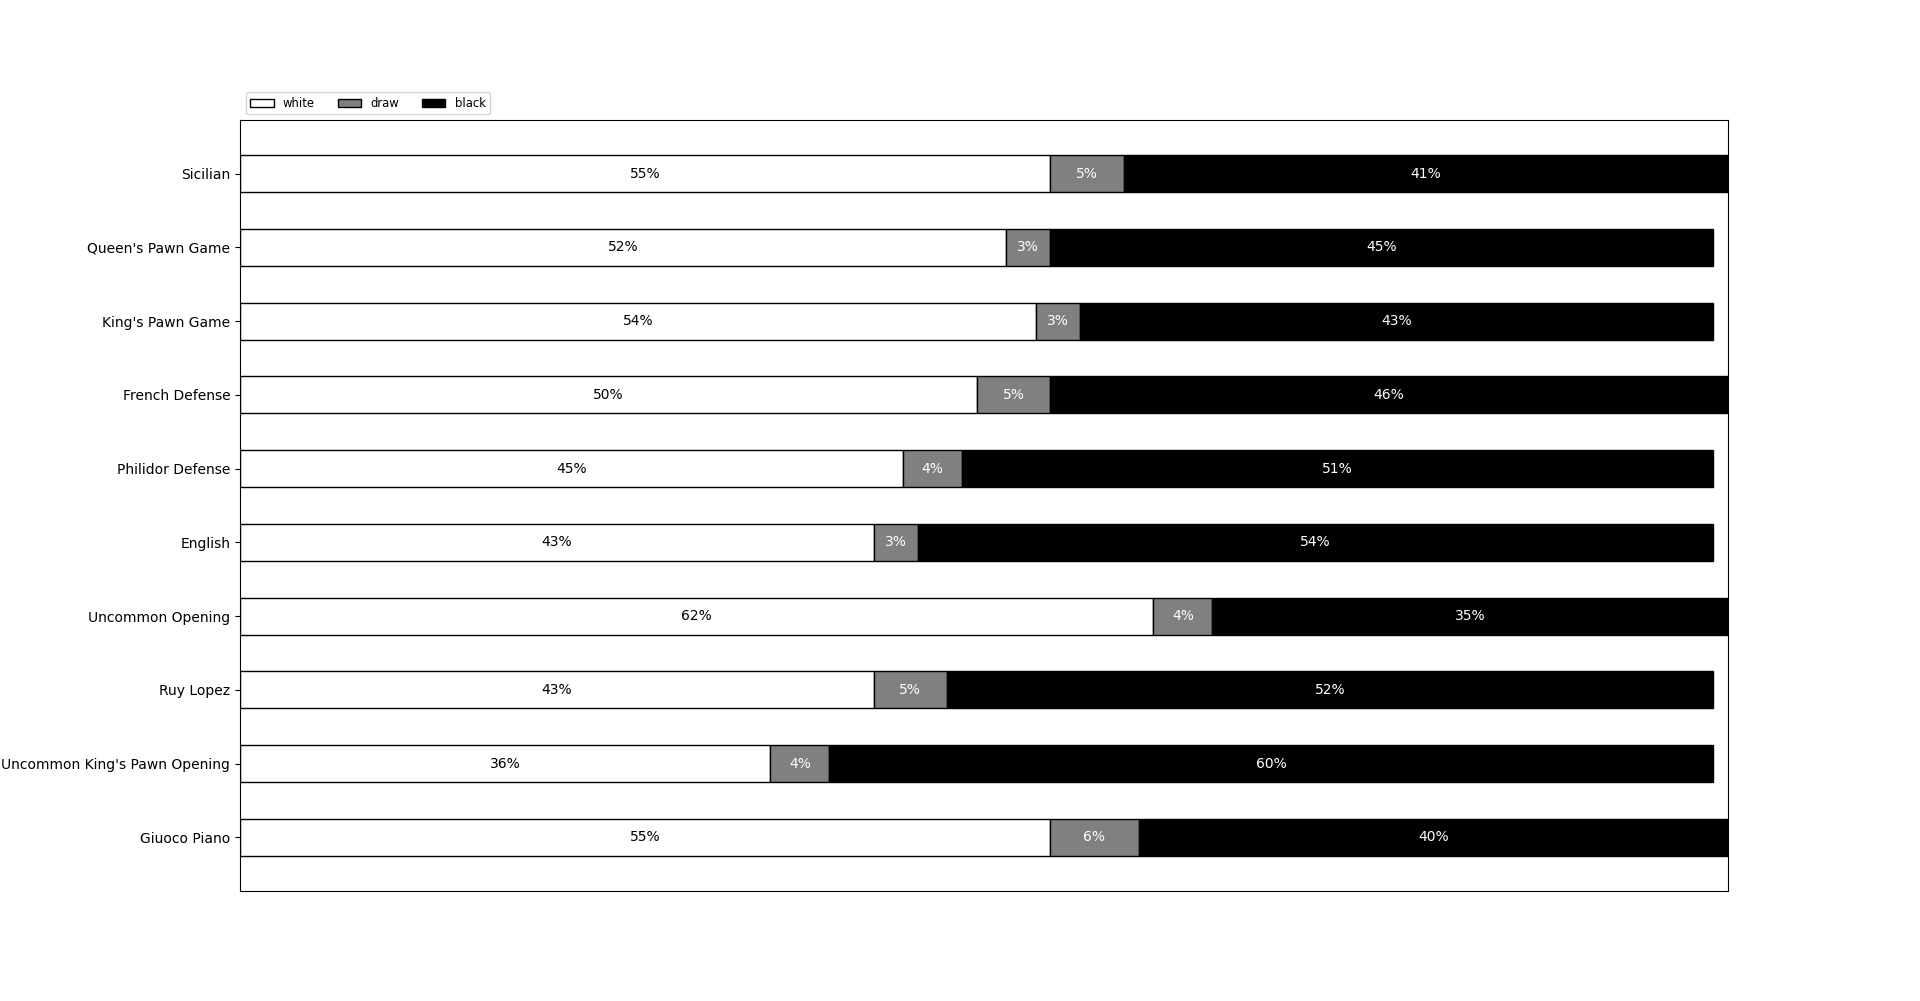


For high rated player (elo >= 1500)
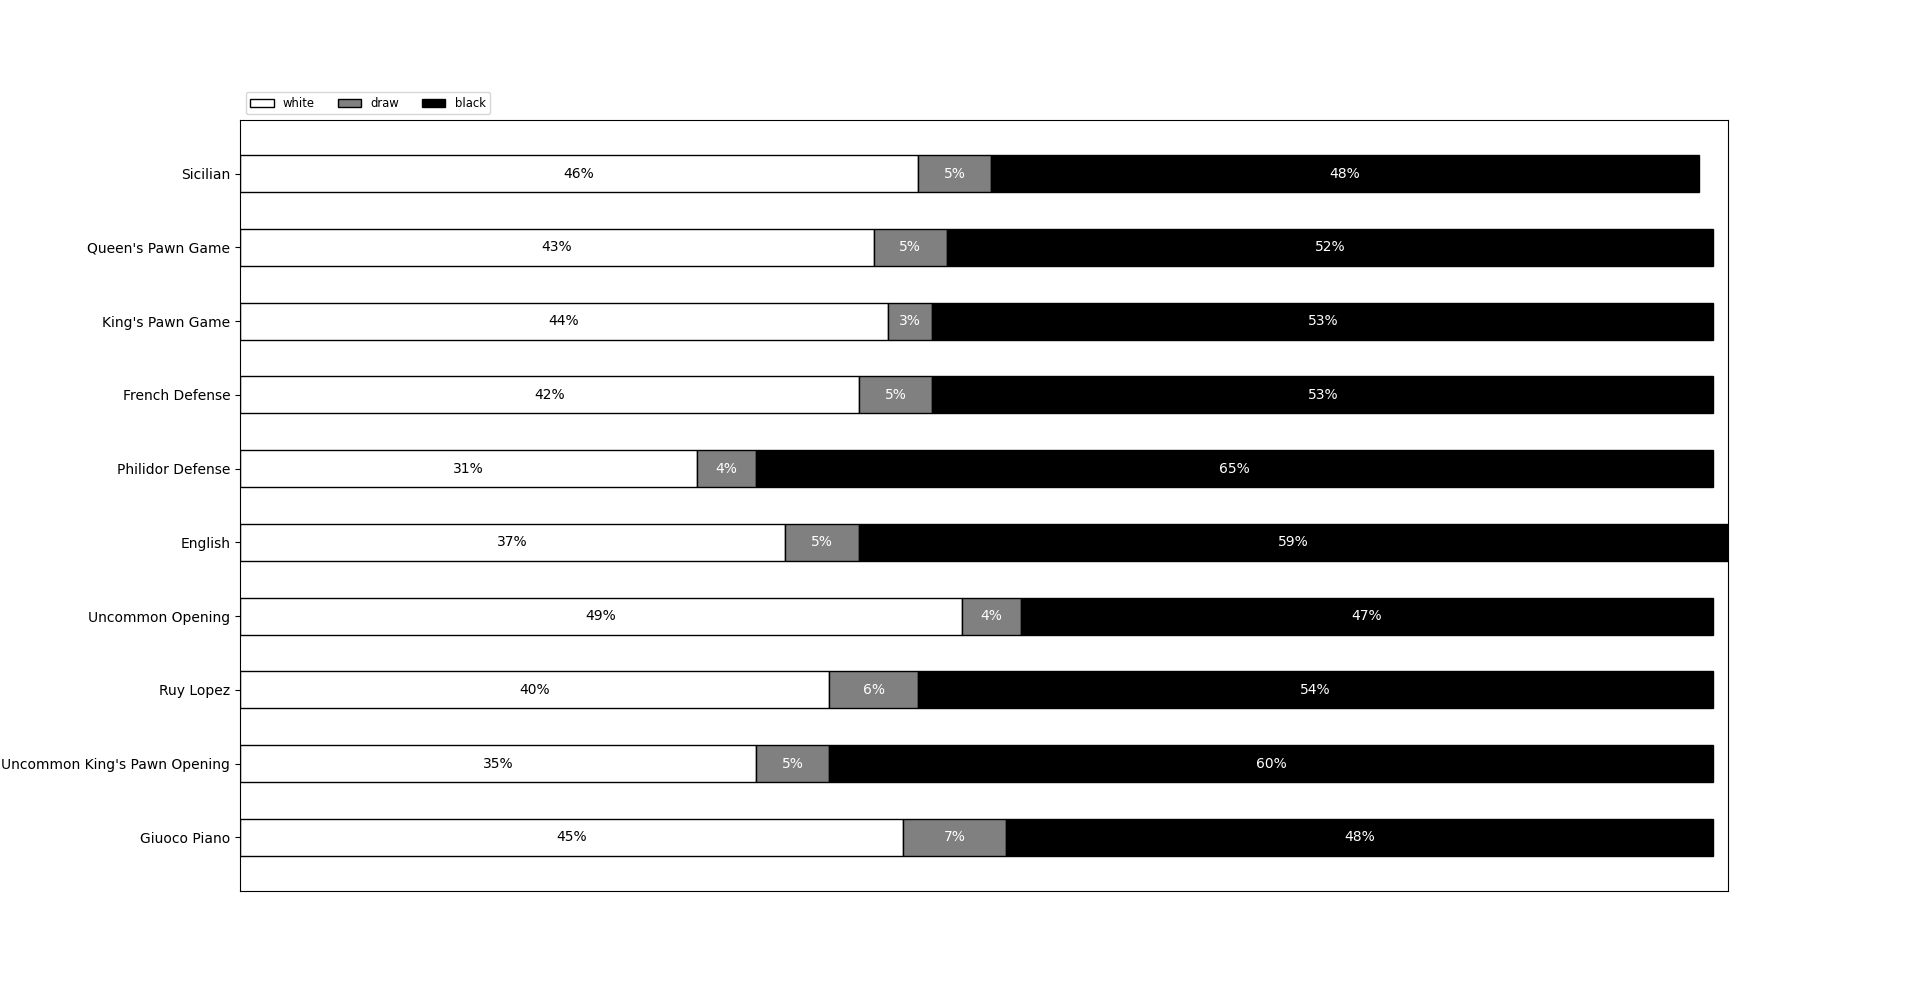


In [ ]:
victory_dataframe = pd.concat([data['victory_status'], data['winner'], data['white_rating'], data['opening_eco']],
                              axis=1, keys=['victory_status', 'winner', 'white_rating', 'opening_eco'])
victory_dataframe = victory_dataframe.replace({'opening_eco': opening_eco})

elo_condition = victory_dataframe['white_rating'] >= 1500
labels = most_played_openings
opening_condition = victory_dataframe['opening_eco'].isin(labels)

category_names = ['white', 'draw', 'black']
category_colors = ['white', 'grey', 'black']
text_colors = ['black', 'white', 'white']

step1_dataframe = victory_dataframe[elo_condition & opening_condition]
step1_dataframe = step1_dataframe.groupby(['opening_eco', 'winner']).size()

winner_data = []
for label in labels:
    winner_data.append(step1_dataframe[label])
winner_data = np.array(winner_data)
winner_data, bar_labels = array_to_percent(winner_data)

cumsum = winner_data.cumsum(axis=1)
fig, ax = plt.subplots(figsize=(15, 4))
ax.xaxis.set_visible(False)
ax.invert_yaxis()
ax.set_xlim(0, np.sum(winner_data, axis=1).max())
for i, (category, color) in enumerate(zip(category_names, category_colors)):
    widths = winner_data[:, i]
    starts = cumsum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.5, color=color, label=category, edgecolor='black')
    ax.bar_label(rects, labels=bar_labels[i], label_type='center', color=text_colors[i])
ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')

We can also take a closer look at a few openings to see their efficiency variation for White and Black regarding their elo.

As you will see on the following graphs, openings strength is not identical regarding the elo at which the game takes place. Some seems more advantageous for Black at low level (e.g. the Giuoco Piano), others for White at high level (e.g. the French Defense) and some are rather unclear (e.g. the Scandiniavian).

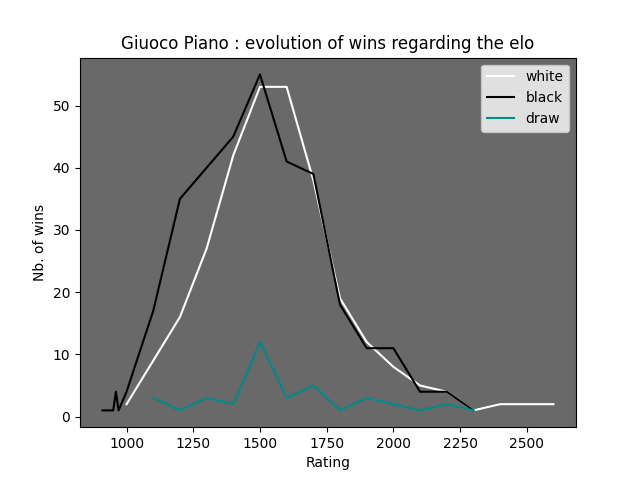

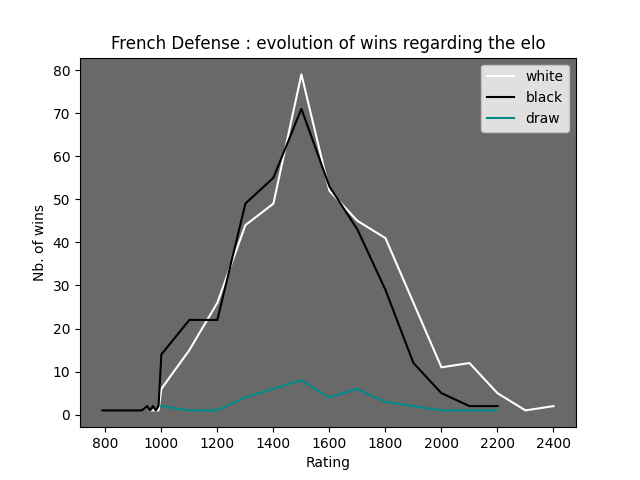

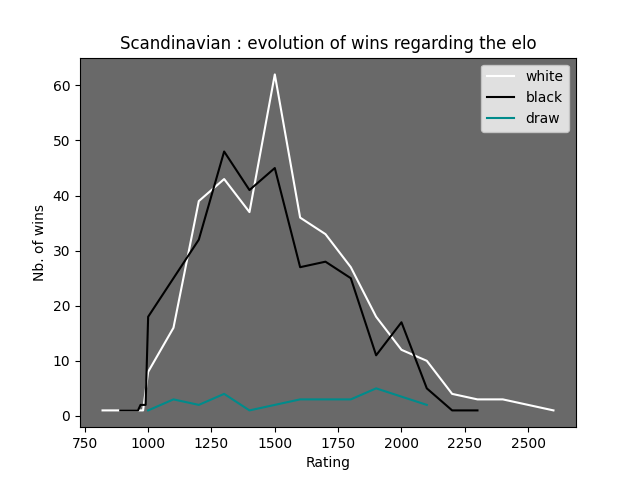

In [ ]:
# Variation of the winning percentage for 3 curves (black, white, draw) regarding the elo and a specific opening
victory_dataframe = pd.concat([data['winner'], data['white_rating'], data['opening_eco']],
                              axis=1, keys=['winner', 'rating', 'opening_eco'])
victory_dataframe = victory_dataframe.replace({'opening_eco': opening_eco})
labels = ['Giuoco Piano']
opening_condition = victory_dataframe['opening_eco'].isin(labels)
white_condition = victory_dataframe['winner'] == 'white'
black_condition = victory_dataframe['winner'] == 'black'
draw_condition = victory_dataframe['winner'] == 'draw'
white_step2_dataframe = victory_dataframe[opening_condition & white_condition]
black_step2_dataframe = victory_dataframe[opening_condition & black_condition]
draw_step2_dataframe = victory_dataframe[opening_condition & draw_condition]
white_step2_dataframe = white_step2_dataframe.groupby(['rating']).size()
black_step2_dataframe = black_step2_dataframe.groupby(['rating']).size()
draw_step2_dataframe = draw_step2_dataframe.groupby(['rating']).size()
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(white_step2_dataframe.keys(), white_step2_dataframe.values, color='white', label='white')
ax.plot(black_step2_dataframe.keys(), black_step2_dataframe.values, color='black', label='black')
ax.plot(draw_step2_dataframe.keys(), draw_step2_dataframe.values, color='darkcyan', label='draw')
ax.set_facecolor('dimgrey')
ax.set_xlabel('Rating')
ax.set_ylabel('Nb. of wins')
ax.set_title('Giuoco Piano : evolution of wins regarding the elo')
ax.legend(loc='upper right')

* Ratings gap impact

I arbitrarily calculated the elo gap as the difference between white and black ratings. That means that white is higher rated than black for a positive gap, and lower rated for a negative one.
This graph is very interesting, as it clearly shows white dominance when the elo gap is small. As expected a much higher rated player is more likely to win for either sides when the gap grows.

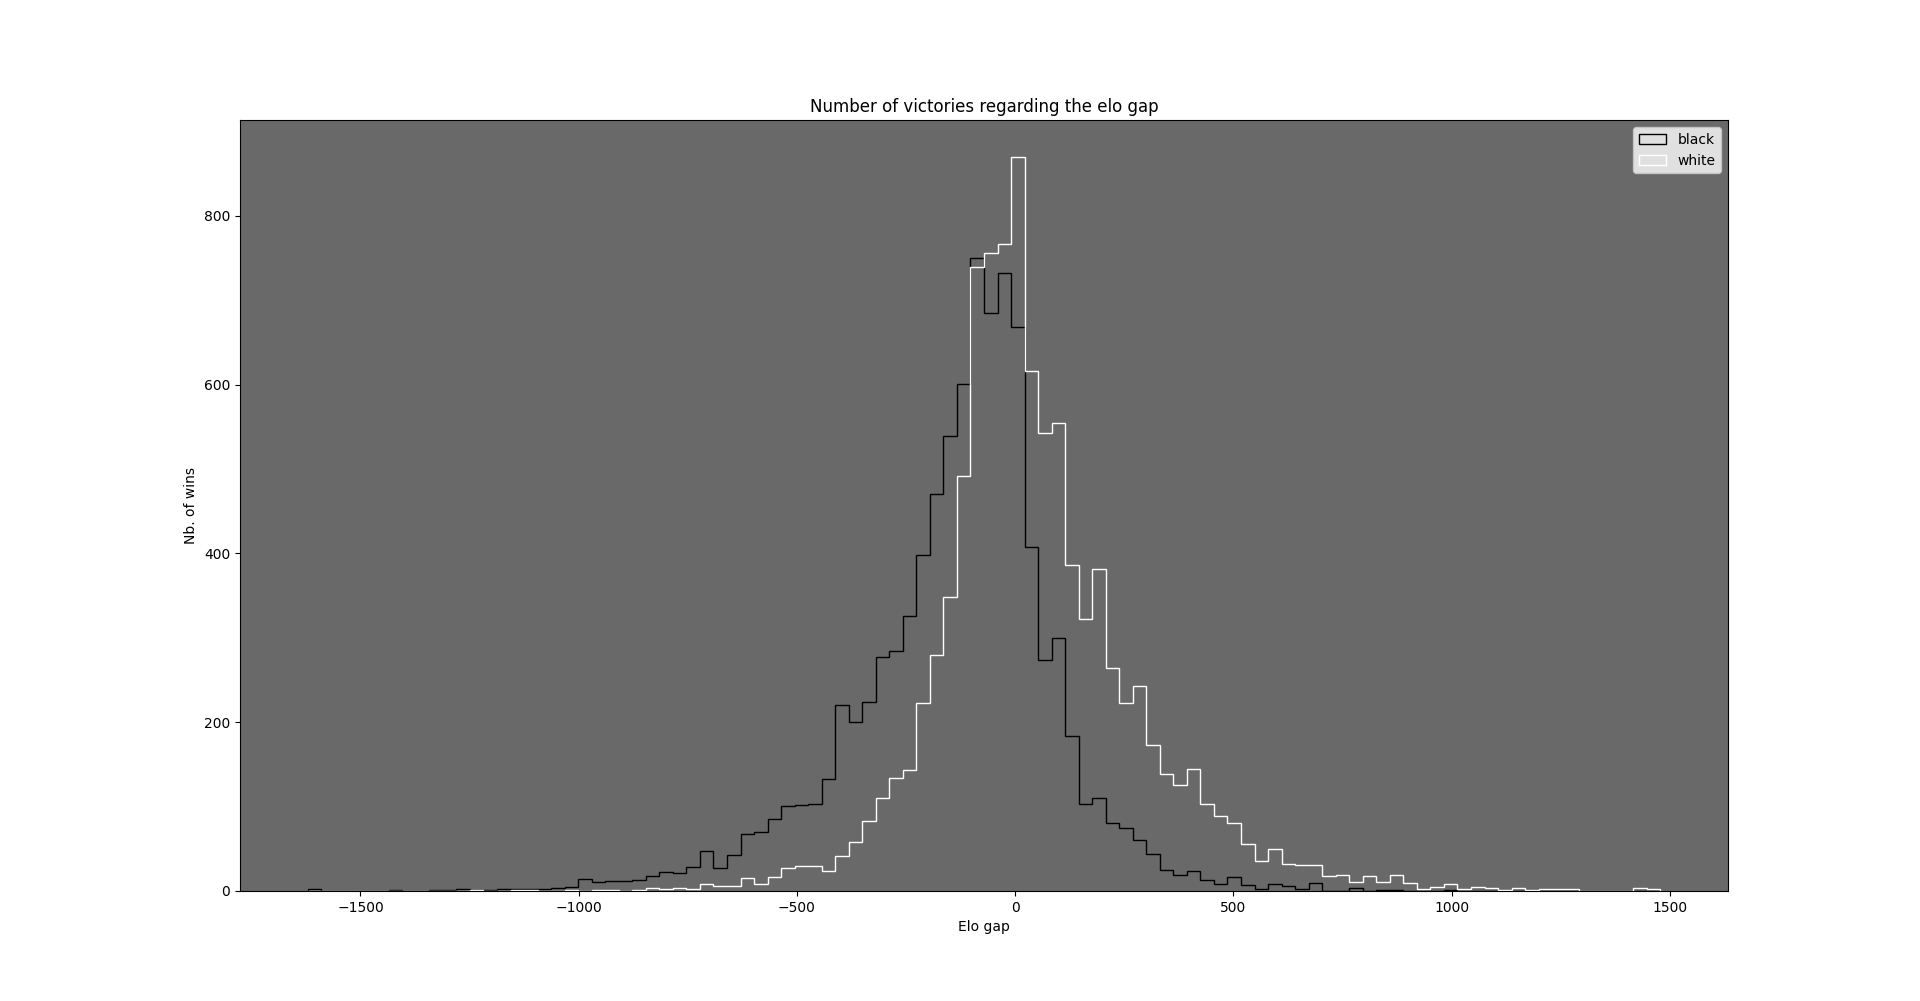

In [ ]:
dataframe = pd.concat([data['winner'], data['white_rating'], data['black_rating']], axis=1,
                      keys=['winner', 'white_rating', 'black_rating'])
dataframe['elo_gap'] = dataframe.apply(lambda row: row.white_rating - row.black_rating, axis=1)
white_win = dataframe[dataframe['winner'] == 'white']
black_win = dataframe[dataframe['winner'] == 'black']
fig, ax = plt.subplots(nrows=1, ncols=1)
colors = ['white', 'black']
ax.set_facecolor('dimgrey')
ax.hist([white_win['elo_gap'], black_win['elo_gap']], bins=100, histtype='step', fill=False, color=colors, label=colors)
ax.set_xlabel('Elo gap')
ax.set_ylabel('Nb. of wins')
ax.set_title('Number of victories regarding the elo gap')
ax.legend()

# Prediction experience : can we predict the winner only after the opening moves ?

**Baseline**

For this part I used code from another notebook, in order to test multiple basic methods to have a baseline of the results that could be obtained.
In order to stick with our use case, predicting the winner, there are only a few variables that we can keep for the analysis : increment_type, white rating, black rating and opening eco (dropping all other values). Here are the results for each method :

- Decision Tree : 56% accuracy
- Random Forest : 64% accuracy
- Gradient Boost : 62% accuracy

**Using neural networks**

The whole point of this analysis is to try and match the baseline (or even do better if possible !) using a neural network.
I personally started my training with Keras. For this problem I used stacked dense layers to predict after the opening moves if the game will be won by white, black, or end in a draw.

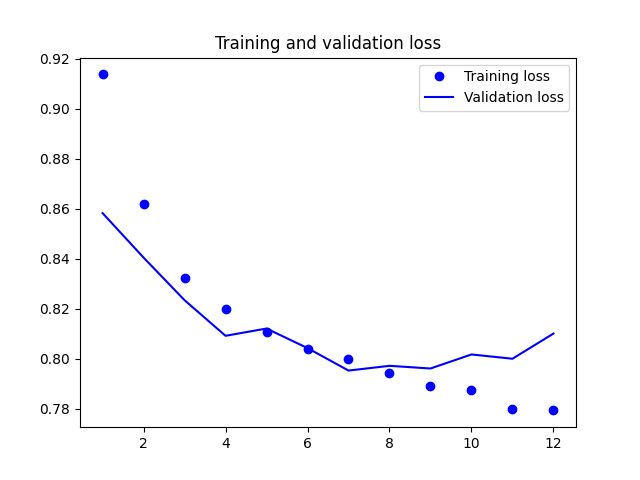

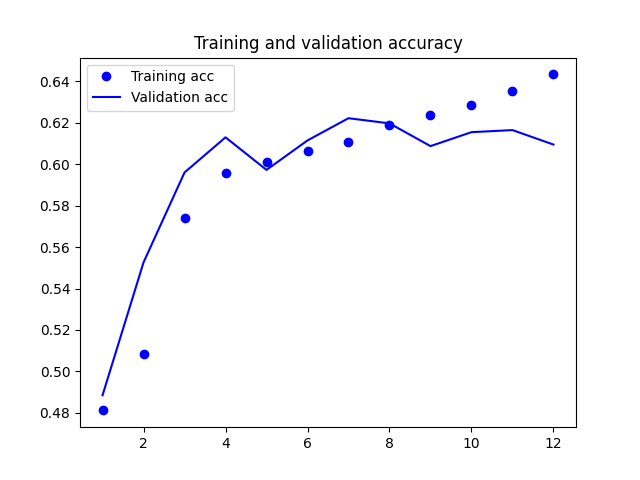

    test loss, test accuracy:  [0.8192183971405029, 0.6026919484138489]
    
**Conclusion**

Surely the network performances could be improved, but we still were able to match the baseline which is encouraging !